In [63]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from torch import Tensor

from models.classifier import AmNewsClassifier, load_dataset
from preprocessing.pipeline import PreprocessingPipeline

In [105]:
data = pd.read_csv("data/am_news_corpus.csv")

61915


In [106]:
print(f"Dataset has {data.count()} entries.")
data.info()

Dataset has article     61915
category    61915
dtype: int64 entries.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61915 entries, 0 to 61914
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   article   61915 non-null  object
 1   category  61915 non-null  object
dtypes: object(2)
memory usage: 967.6+ KB


In [107]:
preprocess = PreprocessingPipeline()
data = data.dropna()
classes = data["category"].unique()

data["category_num"] = pd.factorize(data["category"])[0]
data["article"] = data["article"].apply(preprocess)

# shuffle the df
data = data.sample(frac=1, random_state=4).reset_index(drop=True)

<Axes: xlabel='category'>

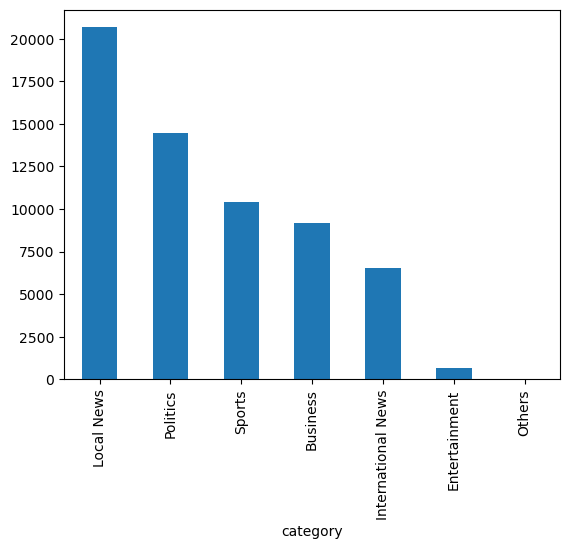

In [108]:
data["category"].value_counts().plot(kind='bar')

In [49]:
articles, labels = data["article"], data["category_num"]

In [109]:
train_split = 0.8
split_idx = int(articles.count() * train_split)

articles_train, labels_train = articles[:split_idx], labels[:split_idx]
articles_test, labels_test = articles[split_idx:], labels[split_idx:]

In [110]:
vectorizer = TfidfVectorizer(analyzer='word', max_features=512, ngram_range=(1, 3))
vectorizer.fit(articles_train)
with open("models/trained/tfidfvectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

In [111]:
X_train, y_train = vectorizer.transform(articles_train).toarray(), labels_train.array
X_test, y_test = vectorizer.transform(articles_test).toarray(), labels_test.array

In [112]:
# prepare validation dataset from train dataset
val_size = 1000
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

batch_size = 32
train_loader = load_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
val_loader = load_dataset(X_val, y_val, batch_size=32)
test_loader = load_dataset(X_test, y_test)

Epoch 1 Train Loss: 0.800125763342259, Val Loss: 0.5758405923843384
Epoch 2 Train Loss: 0.5653727319755941, Val Loss: 0.5369750261306763
Epoch 3 Train Loss: 0.5234602025122779, Val Loss: 0.5082495808601379
Epoch 4 Train Loss: 0.4957926508015508, Val Loss: 0.499324232339859
Epoch 5 Train Loss: 0.4713121948787456, Val Loss: 0.47585421800613403
Epoch 6 Train Loss: 0.45005380617347873, Val Loss: 0.48311275243759155
Epoch 7 Train Loss: 0.4303892485227934, Val Loss: 0.46465009450912476
Epoch 8 Train Loss: 0.41263082083670577, Val Loss: 0.45185142755508423
Epoch 9 Train Loss: 0.3950109786478577, Val Loss: 0.4846538007259369
Epoch 10 Train Loss: 0.3783852563470982, Val Loss: 0.4806053936481476
Epoch 11 Train Loss: 0.36242807714660075, Val Loss: 0.47374653816223145
Epoch 12 Train Loss: 0.34699971711702027, Val Loss: 0.4686267077922821
Epoch 13 Train Loss: 0.331296476606683, Val Loss: 0.4744858741760254
Epoch 14 Train Loss: 0.31603300458140626, Val Loss: 0.4835771322250366
Epoch 15 Train Loss: 0

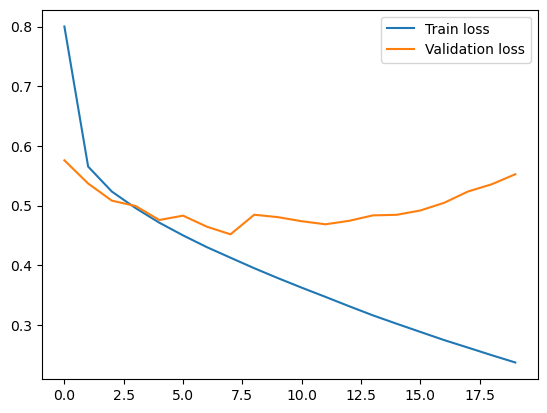

In [116]:
classifier = Classifier(
    input_size=512,
    hidden_sizes=[64, 16],
    output_size=6
)

train_losses, val_losses = classifier.fit(train_loader, val_loader, epochs=10, lr=0.001, verbose=True)

plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.show()

In [117]:
train_accuracy = classifier.evaluate(Tensor(X_train), Tensor(y_train))
test_accuracy = classifier.evaluate(Tensor(X_test), Tensor(y_test))
print("Test accuracy:", test_accuracy)
print("Train accuracy:", train_accuracy)

Test accuracy: 0.8009520173072815
Train accuracy: 0.9283154010772705
